<div style="height:80px; background-color:#C5DABE; font-family:Arial; color:#4B296B; font-size:45px; font-weight:Bold; text-align:center; border:2px solid #618E52; border-radius:10px; padding-top:4px;">Movies Recommendation System</div>

In [418]:

import numpy as np # linear algebra
import matplotlib.pyplot as plt # for platting graph
%matplotlib inline
import seaborn as sns # for data visulization
import warnings # to ignore any warnings
warnings.filterwarnings("ignore")
import json
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

<div style="height:60px; font-family:Arial; color:#4B296B; font-size:30px; font-weight:Bold; text-align:center; border:2px solid #618E52; border-radius:10px; padding-top:8px;">Data Loading...</div>

In [243]:
movies=pd.read_csv('tmdb_5000_movies.csv')
credits=pd.read_csv('tmdb_5000_credits.csv')

<div style="height:60px; font-family:Arial; color:#4B296B; font-size:30px; font-weight:Bold; text-align:center; border:2px solid #618E52; border-radius:10px; padding-top:6px;">Exploratory Data Analysis</div>

In [244]:
movies.shape

(4803, 20)

In [245]:
credits.shape

(4803, 4)

In [246]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


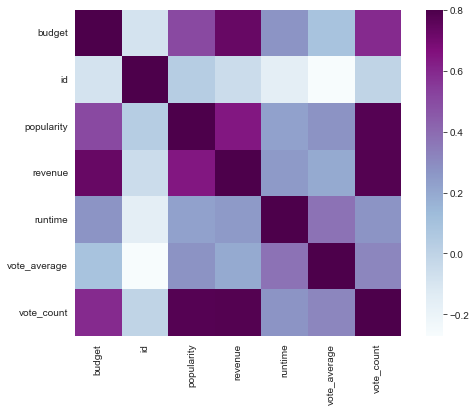

In [247]:
matrix = movies.corr() 
f, ax = plt.subplots(figsize=(9, 6)) 
sns.heatmap(matrix, vmax=.8, square=True, cmap="BuPu");

In [248]:
movie=movies.merge(credits,on='title')

In [249]:
movie.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


<div style="height:60px; font-family:Arial; color:#4B296B; font-size:30px; font-weight:Bold; text-align:center; border:2px solid #618E52; border-radius:10px; padding-top:6px;">Data Merging</div>

In [250]:
movie1=movie[['movie_id','title','overview','genres','keywords','cast','crew']]

In [251]:
movie1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4809 entries, 0 to 4808
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4809 non-null   int64 
 1   title     4809 non-null   object
 2   overview  4806 non-null   object
 3   genres    4809 non-null   object
 4   keywords  4809 non-null   object
 5   cast      4809 non-null   object
 6   crew      4809 non-null   object
dtypes: int64(1), object(6)
memory usage: 300.6+ KB


In [252]:
movie1.head(4)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."


In [253]:
movie1.isnull().sum()

movie_id    0
title       0
overview    3
genres      0
keywords    0
cast        0
crew        0
dtype: int64

In [254]:
movie1.dropna(inplace=True)

In [255]:
movie1.duplicated().sum()

0

In [256]:
movie1.iloc[0].genres

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [352]:
top_100_revenue = movies.sort_values(by='revenue', ascending=False)[:100]

# Extract the production companies from the top 100 revenue movies to a dict type
companies_by_top100 = {}
for companies in top_100_revenue['production_companies']:
    for company in companies:
        if company in companies_by_top100:
            companies_by_top100[company] += 1 
        else: companies_by_top100[company] = 1
            
# Sort the top companies in descending order
companies_by_top100 = dict(sorted(companies_by_top100.items(), key=lambda item: item[1], reverse=True))
# convert to list of tuples 
companies_by_top100 = [(k,v) for k,v in companies_by_top100.items()]

# Top 10 companies
top_revenue_10_companies = companies_by_top100[:10]
top_revenue_10_companies

[('Warner Bros.', 15),
 ('Walt Disney Pictures', 14),
 ('Paramount Pictures', 11),
 ('Columbia Pictures', 10),
 ('Twentieth Century Fox Film Corporation', 7),
 ('Marvel Studios', 7),
 ('Amblin Entertainment', 7),
 ('Universal Pictures', 7),
 ('Revolution Sun Studios', 7),
 ('Legendary Pictures', 6)]

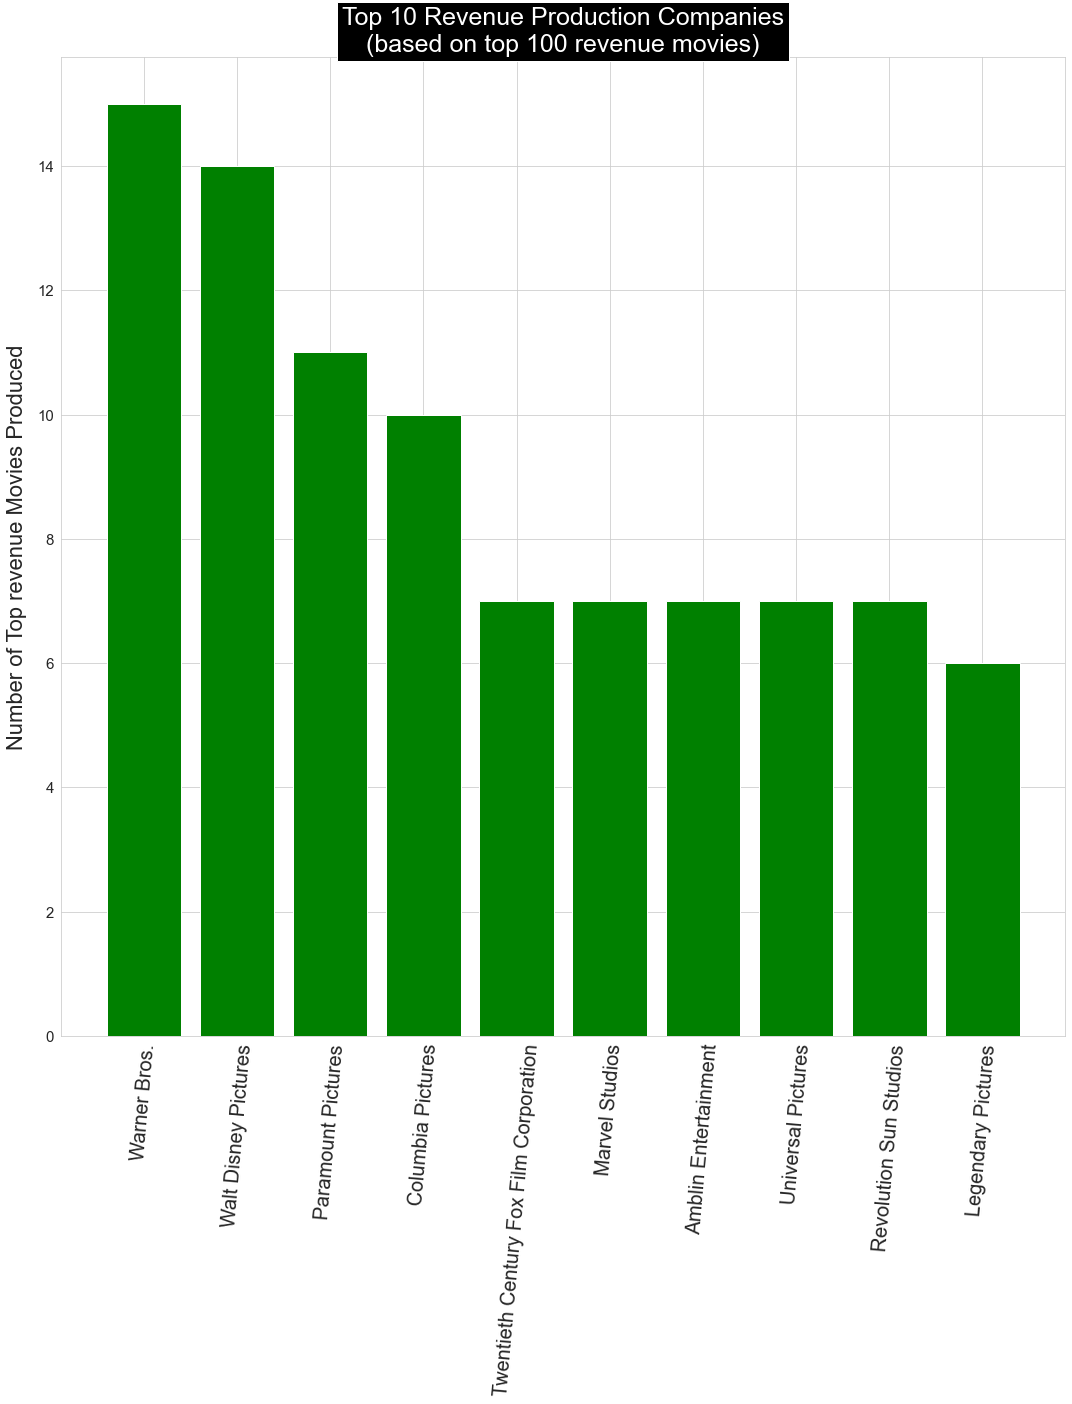

In [353]:
sns.set_style('whitegrid')  # Set a style for the background of the chart
f, ax = plt.subplots(figsize=(18,18)) 
top_10 = list(zip(*top_revenue_10_companies))[0]  # The x axis is the top 10 companies names
frequancies = list(zip(*top_revenue_10_companies))[1]  # The y axis is the frequancies(number of the movies produced from top 100)
x_label = top_10  # Names of the companies
plt.xticks(rotation=85, fontsize = 20)
plt.yticks(fontsize = 15)
plt.ylabel("Number of Top revenue Movies Produced", fontsize = 22, labelpad = 10)
plt.title('Top 10 Revenue Production Companies\n(based on top 100 revenue movies)' ,bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 25)
ax.bar(top_10, frequancies, align = 'center', color='g');

In [259]:
columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
for col in columns:
    movies[col] = movies[col].apply(json.loads)
movies['release_date'] =  pd.to_datetime(movies['release_date'], format ='%Y-%m-%d')

In [260]:
movies["genres"][0]

[{'id': 28, 'name': 'Action'},
 {'id': 12, 'name': 'Adventure'},
 {'id': 14, 'name': 'Fantasy'},
 {'id': 878, 'name': 'Science Fiction'}]

In [261]:
# We extract the names from the json data
for col in columns: 
    movies[col] = movies[col].map(lambda x:[i['name'] for i in x])

movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007-05-19,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015-10-26,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,49026,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],2012-07-16,1084939099,165.0,[English],Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[Action, Adventure, Science Fiction]",http://movies.disney.com/john-carter,49529,"[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,[Walt Disney Pictures],[United States of America],2012-03-07,284139100,132.0,[English],Released,"Lost in our world, found in another.",John Carter,6.1,2124


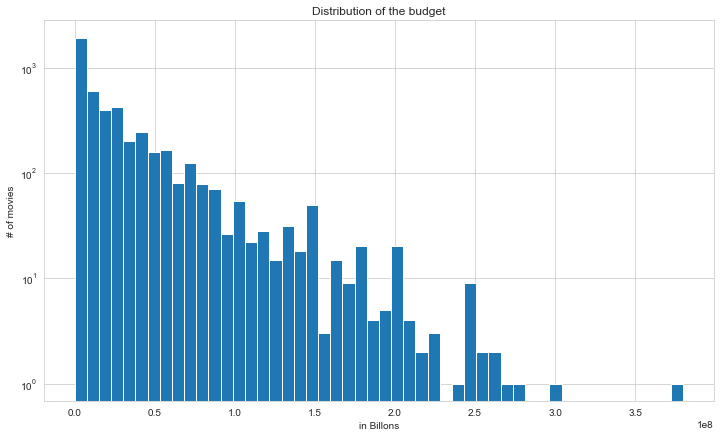

In [411]:
plt.figure(figsize=(12,7))
plt.hist(movies['budget'],bins= 50)
plt.title("Distribution of the budget")
plt.xlabel('in Billons')
plt.ylabel('# of movies')
plt.yscale("log")
plt.show()

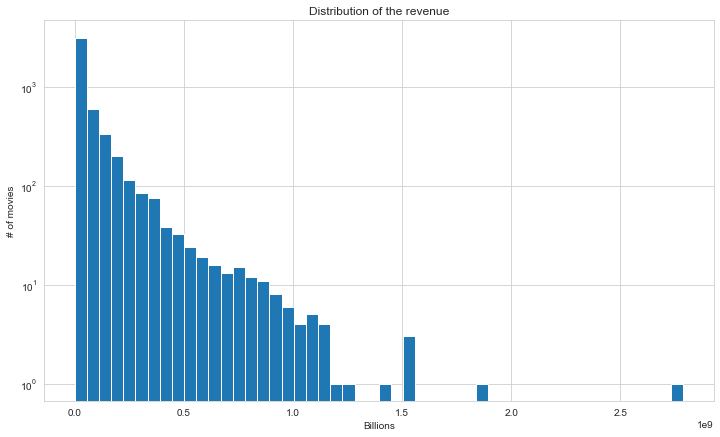

In [263]:
plt.figure(figsize=(12,7))
plt.hist(movies['revenue'],bins= 50)
plt.title("Distribution of the revenue")
plt.xlabel('Billions')
plt.ylabel('# of movies')
plt.yscale("log")
plt.show()

In [264]:
movies_genres = movies.explode("genres")
movies_genres

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,Action,http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800
0,237000000,Adventure,http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800
0,237000000,Fantasy,http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800
0,237000000,Science Fiction,http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,Adventure,http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007-05-19,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4800,0,Drama,http://www.hallmarkchannel.com/signedsealeddel...,231617,"[date, love at first sight, narration, investi...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[Front Street Pictures, Muse Entertainment Ent...",[United States of America],2013-10-13,0,120.0,[English],Released,NaN,"Signed, Sealed, Delivered",7.0,6
4800,0,Romance,http://www.hallmarkchannel.com/signedsealeddel...,231617,"[date, love at first sight, narration, investi...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[Front Street Pictures, Muse Entertainment Ent...",[United States of America],2013-10-13,0,120.0,[English],Released,NaN,"Signed, Sealed, Delivered",7.0,6
4800,0,TV Movie,http://www.hallmarkchannel.com/signedsealeddel...,231617,"[date, love at first sight, narration, investi...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[Front Street Pictures, Muse Entertainment Ent...",[United States of America],2013-10-13,0,120.0,[English],Released,NaN,"Signed, Sealed, Delivered",7.0,6
4801,0,NaN,http://shanghaicalling.com/,126186,[],en,Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,[],"[United States of America, China]",2012-05-03,0,98.0,[English],Released,A New Yorker in Shanghai,Shanghai Calling,5.7,7


In [265]:
movies_genres.genres.unique()

array(['Action', 'Adventure', 'Fantasy', 'Science Fiction', 'Crime',
       'Drama', 'Thriller', 'Animation', 'Family', 'Western', 'Comedy',
       'Romance', 'Horror', 'Mystery', 'History', 'War', 'Music',
       'Documentary', 'Foreign', 'TV Movie', nan], dtype=object)

In [266]:
count_genres = movies_genres.groupby('genres').count()[['id']].sort_values(by='id', ascending=False)
count_genres.head()

,id
genres,
Drama,2297
Comedy,1722
Thriller,1274
Action,1154
Romance,894


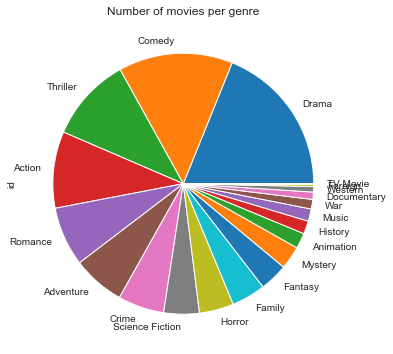

In [267]:
count_genres.plot(kind ='pie',figsize=(10,6),legend = False, subplots = True)
plt.title('Number of movies per genre')
plt.show()

In [268]:
# Select the movies which budget more than 100m and revenue less thna budget
budget100m_failed_movies = movies.query('budget >= 1.0e+08 and revenue < budget')[[ 'production_companies', 'budget','revenue']]

# Adding a new columns containing the revenue-budget proportion
budget100m_failed_movies['revenue_prop'] = budget100m_failed_movies.revenue/budget100m_failed_movies.budget

# Sort the movies by revenue proportion in ascending order
budget100m_failed_movies.sort_values(by='revenue_prop', inplace=True)
budget100m_failed_movies

,production_companies,budget,revenue,revenue_prop
1652,"[Ingenious Film Partners, Twentieth Century Fo...",100000000,0,0.000000
135,"[Universal Pictures, Stuber Productions, Relat...",150000000,0,0.000000
311,"[Village Roadshow Pictures, Castle Rock Entert...",100000000,7103973,0.071040
338,"[Imagine Entertainment, Touchstone Pictures]",145000000,25819961,0.178069
141,[Walt Disney Animation Studios],150000000,38992758,0.259952
13,"[Walt Disney Pictures, Jerry Bruckheimer Films...",255000000,89289910,0.350157
378,"[Paramount Pictures, Intermedia Films, Nationa...",100000000,35168966,0.351690
192,"[Bazmark Films, Ingenious Film Partners, Twent...",130000000,49554002,0.381185
208,[Touchstone Pictures],160000000,61698899,0.385618
226,"[Columbia Pictures, Gracie Films, Road Rebel]",120000000,48668907,0.405574


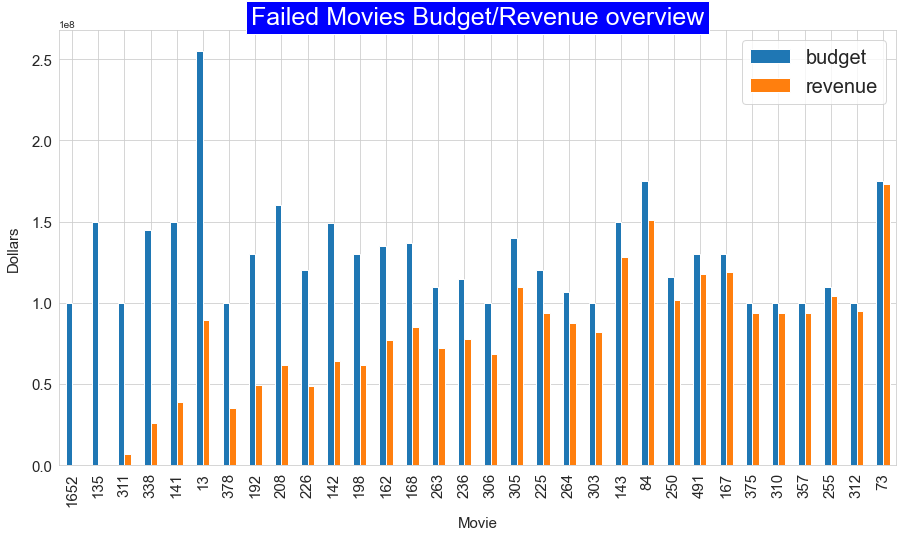

In [269]:

budget100m_failed_movies[['budget','revenue']].plot(kind='bar', figsize=(15,8))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel("Dollars", fontsize = 15, labelpad = 10)
plt.xlabel("Movie", fontsize = 15, labelpad = 10)
plt.legend(prop={'size': 20})
plt.title('Failed Movies Budget/Revenue overview' ,bbox={'facecolor':'b', 'pad':5},color='w',fontsize = 25);

In [270]:
# Will consider the movie is popular if its popularity is more than 5.0 
top_popular_movies = movies.query('popularity >= 5.0')
top_popular_movies

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[Action, Adventure, Fantasy, Science Fiction]",http://www.avatarmovie.com/,19995,"[culture clash, future, space war, space colon...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",2009-12-10,2787965087,162.0,"[English, Español]",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[Adventure, Fantasy, Action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drug abuse, exotic island, east india ...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",[United States of America],2007-05-19,961000000,169.0,[English],Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[Action, Adventure, Crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, based on novel, secret agent, sequel, mi...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[Columbia Pictures, Danjaq, B24]","[United Kingdom, United States of America]",2015-10-26,880674609,148.0,"[Français, English, Español, Italiano, Deutsch]",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[Action, Crime, Drama, Thriller]",http://www.thedarkknightrises.com/,49026,"[dc comics, crime fighter, terrorist, secret i...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[Legendary Pictures, Warner Bros., DC Entertai...",[United States of America],2012-07-16,1084939099,165.0,[English],Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[Action, Adventure, Science Fiction]",http://movies.disney.com/john-carter,49529,"[based on novel, mars, medallion, space travel...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,[Walt Disney Pictures],[United States of America],2012-03-07,284139100,132.0,[English],Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4758,4000000,"[Thriller, Science Fiction]",https://www.facebook.com/thesignalfilm,242095,"[hacker, supernatural powers, road trip, indep...",en,The Signal,Three college students on a road trip across t...,27.662696,"[Automatik Entertainment, Low Spark Films, Sig...",[United States of America],2014-03-15,600896,95.0,[English],Released,R U Agitated?,The Signal,5.8,631
4773,27000,[Comedy],http://www.miramax.com/movie/clerks/,2292,"[salesclerk, loser, aftercreditsstinger]",en,Clerks,Convenience and video store clerks Dante and R...,19.748658,"[Miramax Films, View Askew Productions]",[United States of America],1994-09-13,3151130,92.0,[English],Released,Just because they serve you doesn't mean they ...,Clerks,7.4,755
4778,0,"[Action, Drama, Crime, Thriller]",NaN,38780,"[rampage, massacre, killing spree]",en,Rampage,The boredom of small town life is eating Bill ...,7.101197,"[Boll Kino Beteiligungs GmbH & Co. KG, Brightl...","[Canada, Germany]",2009-08-14,0,85.0,[English],Released,Vengeance is ruthless.,Rampage,6.0,131
4796,7000,"[Science Fiction, Drama, Thriller]",http://www.primermovie.com,14337,"[distrust, garage, identity crisis, time trave...",en,Primer,Friends/fledgling entrepreneurs invent a devic...,23.307949,[Thinkfilm],[United States of America],2004-10-08,424760,77.0,[English],Released,What happens if it actually works?,Primer,6.9,658


In [271]:

# Extract the genres from the top popular movies to a dict type
top_populars_genres = {}
for genres in top_popular_movies['genres']:
    for genre in genres:
        if genre in top_populars_genres:
            top_populars_genres[genre] += 1 
        else: top_populars_genres[genre] = 1
            
# Sort the top popular genres in descending order
top_populars_genres = dict(sorted(top_populars_genres.items(), key=lambda item: item[1], reverse=True))
# convert to list of lists 
top_populars_genres = [[k,v] for k,v in top_populars_genres.items()]
top_populars_genres

[['Drama', 1617],
 ['Comedy', 1270],
 ['Thriller', 1049],
 ['Action', 959],
 ['Adventure', 689],
 ['Romance', 624],
 ['Crime', 583],
 ['Science Fiction', 451],
 ['Family', 412],
 ['Horror', 406],
 ['Fantasy', 382],
 ['Mystery', 291],
 ['Animation', 207],
 ['History', 143],
 ['Music', 125],
 ['War', 110],
 ['Western', 62],
 ['Documentary', 30],
 ['TV Movie', 3]]

In [272]:
import ast

In [273]:
def convert(obj):
    L = []
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L

In [274]:
movie1['genres'] = movie1['genres'].apply(convert)
movie1.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [275]:
movie1['genres']

0       [Action, Adventure, Fantasy, Science Fiction]
1                        [Adventure, Fantasy, Action]
2                          [Action, Adventure, Crime]
3                    [Action, Crime, Drama, Thriller]
4                [Action, Adventure, Science Fiction]
                            ...                      
4804                        [Action, Crime, Thriller]
4805                                [Comedy, Romance]
4806               [Comedy, Drama, Romance, TV Movie]
4807                                               []
4808                                    [Documentary]
Name: genres, Length: 4806, dtype: object

In [276]:
movie1.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [277]:
movie1['keywords']=movie1['keywords'].apply(convert)

In [278]:
movie1['keywords']

0       [culture clash, future, space war, space colon...
1       [ocean, drug abuse, exotic island, east india ...
2       [spy, based on novel, secret agent, sequel, mi...
3       [dc comics, crime fighter, terrorist, secret i...
4       [based on novel, mars, medallion, space travel...
                              ...                        
4804    [united states–mexico barrier, legs, arms, pap...
4805                                                   []
4806    [date, love at first sight, narration, investi...
4807                                                   []
4808            [obsession, camcorder, crush, dream girl]
Name: keywords, Length: 4806, dtype: object

In [279]:
movie1.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [280]:
movie1['cast'][0]

'[{"cast_id": 242, "character": "Jake Sully", "credit_id": "5602a8a7c3a3685532001c9a", "gender": 2, "id": 65731, "name": "Sam Worthington", "order": 0}, {"cast_id": 3, "character": "Neytiri", "credit_id": "52fe48009251416c750ac9cb", "gender": 1, "id": 8691, "name": "Zoe Saldana", "order": 1}, {"cast_id": 25, "character": "Dr. Grace Augustine", "credit_id": "52fe48009251416c750aca39", "gender": 1, "id": 10205, "name": "Sigourney Weaver", "order": 2}, {"cast_id": 4, "character": "Col. Quaritch", "credit_id": "52fe48009251416c750ac9cf", "gender": 2, "id": 32747, "name": "Stephen Lang", "order": 3}, {"cast_id": 5, "character": "Trudy Chacon", "credit_id": "52fe48009251416c750ac9d3", "gender": 1, "id": 17647, "name": "Michelle Rodriguez", "order": 4}, {"cast_id": 8, "character": "Selfridge", "credit_id": "52fe48009251416c750ac9e1", "gender": 2, "id": 1771, "name": "Giovanni Ribisi", "order": 5}, {"cast_id": 7, "character": "Norm Spellman", "credit_id": "52fe48009251416c750ac9dd", "gender": 

In [281]:
def convert3(obj):
    l=[]
    counter=0
    for i in ast.literal_eval(obj):
        if counter!=3:
            l.append(i['name'])
            counter+=1
        else:
            break
    return l       
            

In [282]:
movie1['cast']=movie1['cast'].apply(convert3)

In [283]:
movie1['cast']

0        [Sam Worthington, Zoe Saldana, Sigourney Weaver]
1           [Johnny Depp, Orlando Bloom, Keira Knightley]
2            [Daniel Craig, Christoph Waltz, Léa Seydoux]
3            [Christian Bale, Michael Caine, Gary Oldman]
4          [Taylor Kitsch, Lynn Collins, Samantha Morton]
                              ...                        
4804    [Carlos Gallardo, Jaime de Hoyos, Peter Marqua...
4805         [Edward Burns, Kerry Bishé, Marsha Dietlein]
4806           [Eric Mabius, Kristin Booth, Crystal Lowe]
4807            [Daniel Henney, Eliza Coupe, Bill Paxton]
4808    [Drew Barrymore, Brian Herzlinger, Corey Feldman]
Name: cast, Length: 4806, dtype: object

In [284]:
movie1.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [285]:
movie1['crew'][0]

'[{"credit_id": "52fe48009251416c750aca23", "department": "Editing", "gender": 0, "id": 1721, "job": "Editor", "name": "Stephen E. Rivkin"}, {"credit_id": "539c47ecc3a36810e3001f87", "department": "Art", "gender": 2, "id": 496, "job": "Production Design", "name": "Rick Carter"}, {"credit_id": "54491c89c3a3680fb4001cf7", "department": "Sound", "gender": 0, "id": 900, "job": "Sound Designer", "name": "Christopher Boyes"}, {"credit_id": "54491cb70e0a267480001bd0", "department": "Sound", "gender": 0, "id": 900, "job": "Supervising Sound Editor", "name": "Christopher Boyes"}, {"credit_id": "539c4a4cc3a36810c9002101", "department": "Production", "gender": 1, "id": 1262, "job": "Casting", "name": "Mali Finn"}, {"credit_id": "5544ee3b925141499f0008fc", "department": "Sound", "gender": 2, "id": 1729, "job": "Original Music Composer", "name": "James Horner"}, {"credit_id": "52fe48009251416c750ac9c3", "department": "Directing", "gender": 2, "id": 2710, "job": "Director", "name": "James Cameron"},

In [286]:
def fetch_director(obj):
    l=[]
    for i in ast.literal_eval(obj):
        if i['job'] == 'Director':
            l.append(i['name'])
            break
    return l        

In [287]:
movie1['crew']=movie1['crew'].apply(fetch_director)

In [288]:
movie1.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski]
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes]
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan]
4,49529,John Carter,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton]


In [289]:
movie1['overview']= movie1['overview'].apply(lambda x:x.split())

In [290]:
movie1.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski]
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes]
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan]
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton]


In [291]:
movie1['genres']=movie1['genres'].apply(lambda x:[i.replace(" ","")for i in x])
movie1['keywords']=movie1['keywords'].apply(lambda x:[i.replace(" ","")for i in x])
movie1['cast']=movie1['cast'].apply(lambda x:[i.replace(" ","")for i in x])
movie1['crew']=movie1['crew'].apply(lambda x:[i.replace(" ","")for i in x])

In [292]:
movie1.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron]
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski]
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes]
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan]
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, ScienceFiction]","[basedonnovel, mars, medallion, spacetravel, p...","[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton]


<div style="height:60px; font-family:Arial; color:#4B296B; font-size:30px; font-weight:Bold; text-align:center; border:2px solid #618E52; border-radius:10px; padding-top:6px;">Data-Processing for Movie Tags</div>

In [293]:
movie1['tags']=movie1['overview']+movie1['genres']+movie1['keywords']+movie1['cast']+movie1['crew']

In [294]:
movie1.head()

,movie_id,title,overview,genres,keywords,cast,crew,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron],"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski],"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes],"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan],"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, ScienceFiction]","[basedonnovel, mars, medallion, spacetravel, p...","[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton],"[John, Carter, is, a, war-weary,, former, mili..."


In [295]:
new_data_frame=movie1[['movie_id','title','tags']]

In [296]:
new_data_frame

,movie_id,title,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili..."
...,...,...,...
4804,9367,El Mariachi,"[El, Mariachi, just, wants, to, play, his, gui..."
4805,72766,Newlyweds,"[A, newlywed, couple's, honeymoon, is, upended..."
4806,231617,"Signed, Sealed, Delivered","[""Signed,, Sealed,, Delivered"", introduces, a,..."
4807,126186,Shanghai Calling,"[When, ambitious, New, York, attorney, Sam, is..."


In [297]:
new_data_frame['tags']=new_data_frame['tags'].apply(lambda x:" ".join(x))

In [298]:
new_data_frame.head()

,movie_id,title,tags
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,A cryptic message from Bond’s past sends him o...
3,49026,The Dark Knight Rises,Following the death of District Attorney Harve...
4,49529,John Carter,"John Carter is a war-weary, former military ca..."


In [299]:
new_data_frame['tags']=new_data_frame['tags'].apply(lambda x:x.lower())

In [300]:
new_data_frame.head()

,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."
2,206647,Spectre,a cryptic message from bond’s past sends him o...
3,49026,The Dark Knight Rises,following the death of district attorney harve...
4,49529,John Carter,"john carter is a war-weary, former military ca..."


<div style="height:60px; font-family:Arial; color:#4B296B; font-size:30px; font-weight:Bold; text-align:center; border:2px solid #618E52; border-radius:10px; padding-top:6px;">Steming</div>

In [301]:
import nltk

In [302]:
!pip install nltk

In [303]:
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()

In [304]:
def stem(text):
    y=[]
    for i in text.split():
        y.append(ps.stem(i))
        
    return " ".join(y)    

In [305]:
new_data_frame['tags'][0]

'in the 22nd century, a paraplegic marine is dispatched to the moon pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization. action adventure fantasy sciencefiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d samworthington zoesaldana sigourneyweaver jamescameron'

In [306]:
new_data_frame['tags']=new_data_frame['tags'].apply(stem)

## MODEL1

<div style="height:60px; font-family:Arial; color:#4B296B; font-size:30px; font-weight:Bold; text-align:center; border:2px solid #618E52; border-radius:10px; padding-top:6px;">Vectorization</div>

In [372]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=5000,stop_words='english')

In [373]:
vector=cv.fit_transform(new_data_frame['tags']).toarray()

In [374]:
vector

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [375]:
cv.get_feature_names()

['000',
 '007',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '17th',
 '18',
 '18th',
 '18thcenturi',
 '19',
 '1910',
 '1920',
 '1930',
 '1940',
 '1944',
 '1950',
 '1950s',
 '1960',
 '1960s',
 '1970',
 '1970s',
 '1971',
 '1974',
 '1976',
 '1980',
 '1985',
 '1990',
 '1999',
 '19th',
 '19thcenturi',
 '20',
 '200',
 '2003',
 '2009',
 '20th',
 '21st',
 '23',
 '24',
 '25',
 '30',
 '300',
 '3d',
 '40',
 '50',
 '500',
 '60',
 '70',
 '80',
 'aaron',
 'aaroneckhart',
 'abandon',
 'abduct',
 'abigailbreslin',
 'abil',
 'abl',
 'aboard',
 'abov',
 'abus',
 'academ',
 'academi',
 'accept',
 'access',
 'accid',
 'accident',
 'acclaim',
 'accompani',
 'accomplish',
 'account',
 'accus',
 'ace',
 'achiev',
 'acquaint',
 'act',
 'action',
 'actionhero',
 'activ',
 'activist',
 'activities',
 'actor',
 'actress',
 'actual',
 'ad',
 'adam',
 'adamsandl',
 'adamshankman',
 'adapt',
 'add',
 'addict',
 'adjust',
 'admir',
 'admit',
 'adolesc',
 'adopt',
 'ador',
 'adrienbrodi',
 'adult'

<div style="height:60px; font-family:Arial; color:#4B296B; font-size:30px; font-weight:Bold; text-align:center; border:2px solid #618E52; border-radius:10px; padding-top:4px;">Calculate Vectors Similarities & Distances</div>

Cosine Similarity¶
I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

𝑐𝑜𝑠𝑖𝑛𝑒(𝑥,𝑦)= 𝑥.𝑦 / ||𝑥||.||𝑦|| 

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [376]:
from sklearn.metrics.pairwise import cosine_similarity

In [420]:
similarity=cosine_similarity(vector)

In [389]:
similarity[1]

array([0.08346223, 1.        , 0.06063391, ..., 0.02378257, 0.        ,
       0.02615329])

In [390]:
 sorted(list(enumerate(similarity[0])),reverse=True,key=lambda x:x[1])[1:6]

[(1216, 0.28676966733820225),
 (2409, 0.26901379342448517),
 (3730, 0.2605130246476754),
 (507, 0.255608593705383),
 (539, 0.2503866978335957)]

In [380]:
def recommend(movie):
    movie_index=new_data_frame[new_data_frame['title'] == movie].index[0]
    distances=similarity[movie_index]
    movie_list=sorted(list(enumerate(distances)),reverse=True,key=lambda x:x[1])[1:6]
    
    for i in movie_list:
        print(new_data_frame.iloc[i[0]].title)

<div style="height:80px; background-color:#C5DABE; font-family:Arial; color:#4B296B; font-size:45px; font-weight:Bold; text-align:center; border:2px solid #618E52; border-radius:10px; padding-top:4px;">Recommendations</div>

In [381]:
recommend('Avatar')

Aliens vs Predator: Requiem
Aliens
Falcon Rising
Independence Day
Titan A.E.


## MODEL 2

In [317]:
cv2=CountVectorizer(max_features=500,stop_words='english')

In [318]:
vector2=cv2.fit_transform(new_data_frame['tags']).toarray()

In [319]:
vector2

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [320]:
cv.get_feature_names()

['000',
 '007',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '17th',
 '18',
 '18th',
 '18thcenturi',
 '19',
 '1910',
 '1920',
 '1930',
 '1940',
 '1944',
 '1950',
 '1950s',
 '1960',
 '1960s',
 '1970',
 '1970s',
 '1971',
 '1974',
 '1976',
 '1980',
 '1985',
 '1990',
 '1999',
 '19th',
 '19thcenturi',
 '20',
 '200',
 '2003',
 '2009',
 '20th',
 '21st',
 '23',
 '24',
 '25',
 '30',
 '300',
 '3d',
 '40',
 '50',
 '500',
 '60',
 '70',
 '80',
 'aaron',
 'aaroneckhart',
 'abandon',
 'abduct',
 'abigailbreslin',
 'abil',
 'abl',
 'aboard',
 'abov',
 'abus',
 'academ',
 'academi',
 'accept',
 'access',
 'accid',
 'accident',
 'acclaim',
 'accompani',
 'accomplish',
 'account',
 'accus',
 'ace',
 'achiev',
 'acquaint',
 'act',
 'action',
 'actionhero',
 'activ',
 'activist',
 'activities',
 'actor',
 'actress',
 'actual',
 'ad',
 'adam',
 'adamsandl',
 'adamshankman',
 'adapt',
 'add',
 'addict',
 'adjust',
 'admir',
 'admit',
 'adolesc',
 'adopt',
 'ador',
 'adrienbrodi',
 'adult'

In [321]:
from sklearn.metrics.pairwise import cosine_similarity

In [419]:
similarity2=cosine_similarity(vector2)

In [385]:
similarity2[1]

array([0.17770466, 1.        , 0.11846978, ..., 0.04714045, 0.        ,
       0.06262243])

In [386]:
 sorted(list(enumerate(similarity2[0])),reverse=True,key=lambda x:x[1])[1:6]

[(507, 0.5619514869490164),
 (151, 0.4866642633922876),
 (1216, 0.4640161686673095),
 (1204, 0.45056355688958294),
 (322, 0.44539933408304444)]

In [325]:
new_data_frame[new_data_frame['title'] == 'Avatar'].index[0]

0

In [326]:
def recommend2(movie):
    movie_index=new_data_frame[new_data_frame['title'] == movie].index[0]
    distances=similarity2[movie_index]
    movie_list=sorted(list(enumerate(distances)),reverse=True,key=lambda x:x[1])[1:6]
    
    for i in movie_list:
        print(new_data_frame.iloc[i[0]].title)

In [327]:
recommend2('Avatar')

Independence Day
Beowulf
Aliens vs Predator: Requiem
Predators
The Fifth Element


## MODEL3

In [328]:
cv3=CountVectorizer(max_features=10,stop_words='english')

In [329]:
vector3=cv3.fit_transform(new_data_frame['tags']).toarray()

In [330]:
vector3

array([[1, 1, 0, ..., 0, 1, 0],
       [1, 1, 0, ..., 1, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [331]:
cv3.get_feature_names()

['action',
 'adventur',
 'comedi',
 'drama',
 'famili',
 'ha',
 'hi',
 'life',
 'romanc',
 'thriller']

In [332]:
from sklearn.metrics.pairwise import cosine_similarity

In [333]:
similarity3=cosine_similarity(vector3)

In [334]:
similarity3[1]

array([0.57735027, 1.        , 0.70710678, ..., 0.        , 0.        ,
       0.35355339])

In [335]:
sorted(list(enumerate(similarity3[0])),reverse=True,key=lambda x:x[1])[1:6]

[(50, 1.0000000000000002),
 (83, 0.912870929175277),
 (773, 0.8728715609439696),
 (1327, 0.8728715609439696),
 (490, 0.8660254037844388)]

In [336]:
def recommend3(movie):
    movie_index=new_data_frame[new_data_frame['title'] == movie].index[0]
    distances=similarity3[movie_index]
    movie_list=sorted(list(enumerate(distances)),reverse=True,key=lambda x:x[1])[1:6]
    
    for i in movie_list:
        print(new_data_frame.iloc[i[0]].title)

In [337]:
recommend3('Avatar')

Prince of Persia: The Sands of Time
The Lovers
Flyboys
Virgin Territory
A Sound of Thunder


## MODEL4

In [338]:
cv4=CountVectorizer(max_features=2000)

In [339]:
vector4=cv4.fit_transform(new_data_frame['tags']).toarray()

In [340]:
vector4

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [341]:
cv4.get_feature_names()

['000',
 '10',
 '11',
 '12',
 '15',
 '17',
 '1930',
 '1950',
 '1960',
 '1970',
 '1980',
 '19th',
 '19thcenturi',
 '20',
 '30',
 '3d',
 'aaroneckhart',
 'abandon',
 'abil',
 'abl',
 'about',
 'abus',
 'academi',
 'accept',
 'accid',
 'accident',
 'accompani',
 'account',
 'accus',
 'across',
 'act',
 'action',
 'actor',
 'actress',
 'actual',
 'adam',
 'adamsandl',
 'adapt',
 'addict',
 'adopt',
 'adult',
 'adulteri',
 'adventur',
 'adventure',
 'advic',
 'affair',
 'affect',
 'africa',
 'african',
 'after',
 'aftercreditssting',
 'afterlif',
 'ag',
 'again',
 'against',
 'age',
 'agent',
 'ago',
 'agre',
 'ahead',
 'aid',
 'air',
 'airplan',
 'airport',
 'alaska',
 'alcohol',
 'alecbaldwin',
 'alex',
 'alic',
 'alien',
 'alieninvas',
 'aliv',
 'alive',
 'all',
 'alli',
 'allow',
 'almost',
 'alon',
 'along',
 'alpacino',
 'alreadi',
 'also',
 'alter',
 'altern',
 'although',
 'alway',
 'ambiti',
 'ambush',
 'america',
 'american',
 'americanfootbal',
 'amnesia',
 'among',
 'amp',
 'an'

In [342]:
similarity4=cosine_similarity(vector4)

In [343]:
similarity4[1]

array([0.31209389, 1.        , 0.35527986, ..., 0.30122677, 0.34088933,
       0.20951397])

In [344]:
sorted(list(enumerate(similarity4[0])),reverse=True,key=lambda x:x[1])[1:6]

[(1216, 0.47776654295295456),
 (507, 0.4713227861530891),
 (61, 0.45845460404900223),
 (1089, 0.4558730053911231),
 (300, 0.4441173940978441)]

In [345]:
def recommend4(movie):
    movie_index=new_data_frame[new_data_frame['title'] == movie].index[0]
    distances=similarity4[movie_index]
    movie_list=sorted(list(enumerate(distances)),reverse=True,key=lambda x:x[1])[1:6]
    
    for i in movie_list:
        print(new_data_frame.iloc[i[0]].title)

In [346]:
recommend4('Avatar')

Aliens vs Predator: Requiem
Independence Day
Jupiter Ascending
Aliens in the Attic
Starship Troopers


In [347]:
import pickle

In [348]:
pickle.dump(new_data_frame,open('movies.pkl','wb'))

In [349]:
new_data_frame['title'].values

array(['Avatar', "Pirates of the Caribbean: At World's End", 'Spectre',
       ..., 'Signed, Sealed, Delivered', 'Shanghai Calling',
       'My Date with Drew'], dtype=object)

In [350]:
pickle.dump(new_data_frame.to_dict(),open('movie_dict.pkl','wb'))

In [351]:
pickle.dump(similarity,open('similarity.pkl','wb'))